## CNN para previsão de fraturas

**Acerca do Dataset**
- Este conjunto de dados é composto por imagens de raios X fraturadas e não fraturadas de várias articulações. A tarefa é construir um classificador de imagens para detectar fraturas em determinada imagem de raio-X. Este conjunto de dados é composto por diferentes articulações nas extremidades superiores. O isolamento de articulações individuais é recomendado para melhorar o desempenho dos classificadores.
- 8863 instâncias para treino
- 600 instâncias para teste

### Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Resize

### 0. Preparar o Setup

In [2]:
PATH_TRAIN = './Dataset/train'
PATH_TEST = './Dataset/val'

BATCH_SIZE = 32

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


### 1. Preparar os dados

In [4]:
transform = Compose(
        [ToTensor(),
         Resize((224, 224)),
         #Normalize(mean=(0.1307,), std=(0.3081,)) # TODO: variar este valor para perceber a diferença 
        ])

In [5]:
# Definir a seed

seed = 2024

torch.manual_seed(seed)
np.random.seed(seed)

# Importar dataset

train_dataset = ImageFolder(PATH_TRAIN, transform=transform)
val_dataset = ImageFolder(PATH_TEST, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 1.1 Visualizar os dados

#### 1.1.1 Amostras dos dados

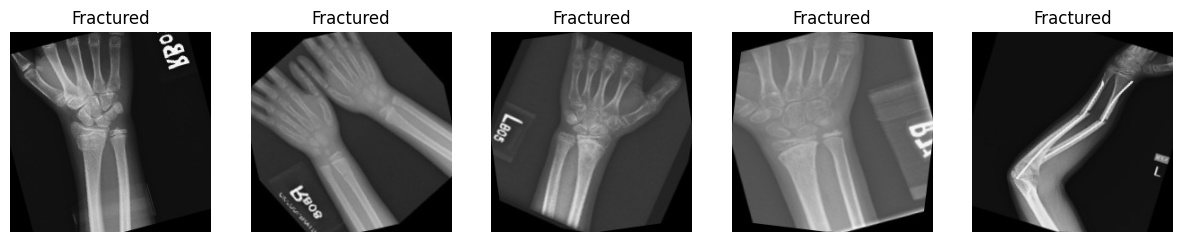

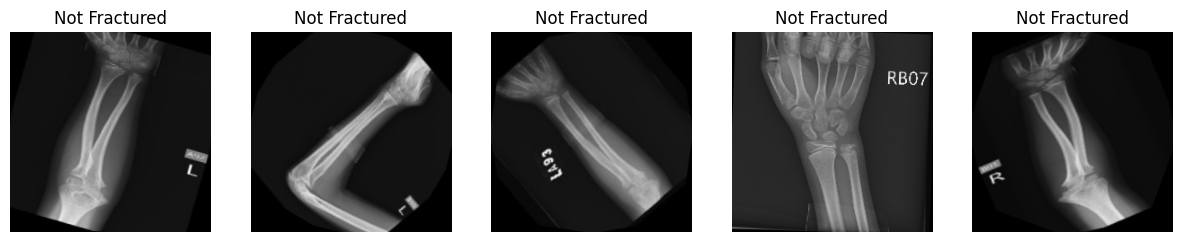

In [7]:
# Função para mostrar imagens
def show_images(images, title):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(title)
        plt.axis('off')
    plt.show()

# selecionar algumas amostras das classes
fractured_samples = []
not_fractured_samples = []
fractured_count = 0
not_fractured_count = 0

# label 0 -> fractured
# label 1 -> not fractured

for images, labels in train_loader:
    for i in range(len(labels)):
        if labels[i] == 0 and fractured_count < 5: 
            fractured_samples.append(images[i])
            fractured_count += 1
        elif labels[i] == 1 and not_fractured_count < 5: 
            not_fractured_samples.append(images[i])
            not_fractured_count += 1
        if fractured_count >= 5 and not_fractured_count >= 5:
            break
    if fractured_count >= 5 and not_fractured_count >= 5:
        break

# imagens de fraturas
show_images(fractured_samples, 'Fractured')

# imagens de não fraturas
show_images(not_fractured_samples, 'Not Fractured')

#### 1.1.2 Tamanho do Dataset

In [20]:
print(f"Quantidade de casos de treino: {len(train_dataset)}")
print(f"Quantidade de casos de teste: {len(val_dataset)}")

x, y = next(iter(train_dataset))
print(f"Shape tensor batch casos treino, input: {x.shape}")

x, y = next(iter(val_dataset))
print(f"Shape tensor batch casos teste, input: {x.shape}")

Quantidade de casos de Treino: 8863
Quantidade de casos de Treino: 600
Shape tensor batch casos treino, input: torch.Size([3, 224, 224])
Shape tensor batch casos teste, input: torch.Size([3, 224, 224])


### 1.2 Balanceamento do Dataset

#### 1.2.1 Balanceamento dos dados de trieno

Número de imagens da classe fractured: 4480
Número de imagens da classe not fractured: 4383


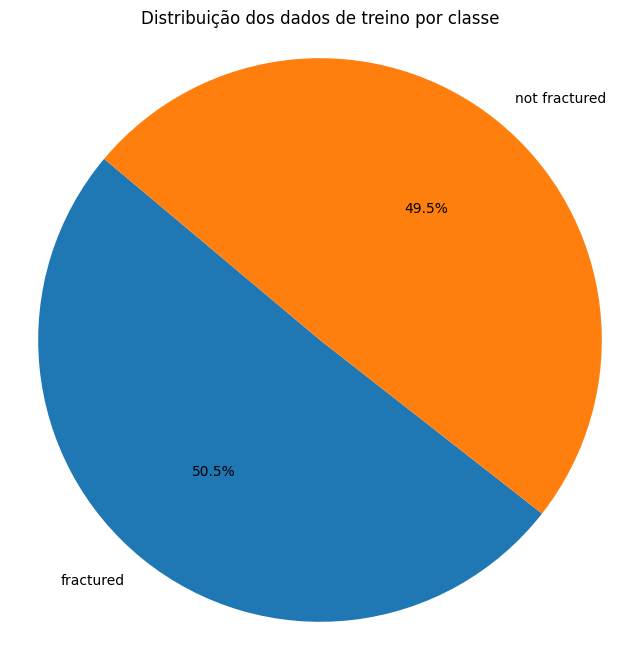

In [25]:
class_counts_train = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset:
    class_name = train_dataset.classes[label]
    class_counts_train[class_name] += 1

classes = list(class_counts_train.keys())
counts = list(class_counts_train.values())

print(f"Número de imagens da classe {classes[0]}: {counts[0]}")
print(f"Número de imagens da classe {classes[1]}: {counts[1]}")

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição dos dados de treino por classe')
plt.axis('equal')
plt.show()

#### 1.2.2 Balanceamento dos dados de teste

Número de imagens da classe fractured: 360
Número de imagens da classe not fractured: 240


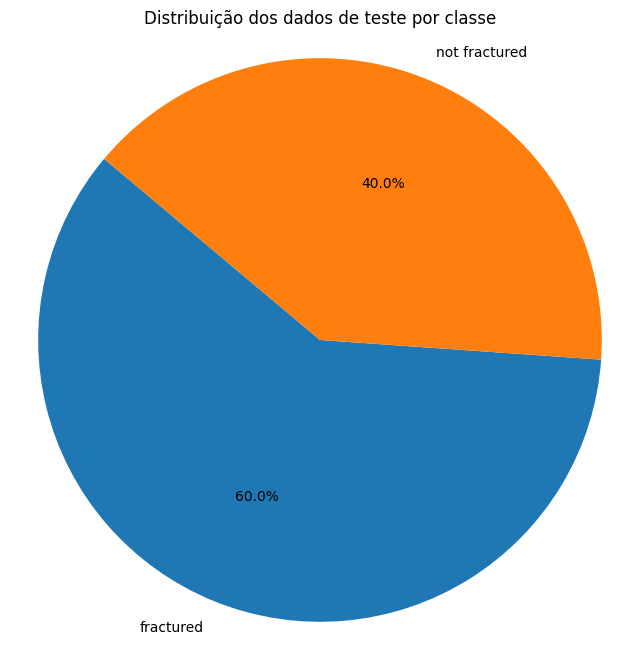

In [26]:
class_counts_test = {class_name: 0 for class_name in val_dataset.classes}
for _, label in val_dataset:
    class_name = val_dataset.classes[label]
    class_counts_test[class_name] += 1

classes = list(class_counts_test.keys())
counts = list(class_counts_test.values())

print(f"Número de imagens da classe {classes[0]}: {counts[0]}")
print(f"Número de imagens da classe {classes[1]}: {counts[1]}")

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição dos dados de teste por classe')
plt.axis('equal')
plt.show()

### 2. Definir os Modelos 